In [136]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

### Model

In [188]:
# Define a simple U-Net style model with 4 output classes
class SmallUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(SmallUNet, self).__init__()
        # First downsampling block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)
        
        # Second downsampling block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Bottleneck block
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # First upsampling block: upsample and combine with conv2 features
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Second upsampling block: upsample and combine with conv1 features
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_up1 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # Final output layer (1x1 conv) maps features to 4 class logits per pixel
        self.out_conv = nn.Conv2d(16, num_classes, kernel_size=1)
    
    def forward(self, x):
        # Downsampling
        c1 = self.conv1(x)         # [B, 16, H, W]
        p1 = self.pool1(c1)        # [B, 16, H/2, W/2]
        c2 = self.conv2(p1)        # [B, 32, H/2, W/2]
        p2 = self.pool2(c2)        # [B, 32, H/4, W/4]
        
        # Bottleneck
        bn = self.bottleneck(p2)   # [B, 64, H/4, W/4]
        
        # Upsampling stage 1
        u2 = self.up2(bn)          # [B, 64, H/2, W/2]
        # Adjust size if needed
        diffY = c2.size()[2] - u2.size()[2]
        diffX = c2.size()[3] - u2.size()[3]
        u2 = F.pad(u2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Concatenate skip connection from conv2
        u2 = torch.cat([u2, c2], dim=1)  # [B, 64+32, H/2, W/2]
        c3 = self.conv_up2(u2)     # [B, 32, H/2, W/2]
        
        # Upsampling stage 2
        u1 = self.up1(c3)          # [B, 32, H, W]
        diffY = c1.size()[2] - u1.size()[2]
        diffX = c1.size()[3] - u1.size()[3]
        u1 = F.pad(u1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Concatenate skip connection from conv1
        u1 = torch.cat([u1, c1], dim=1)  # [B, 32+16, H, W]
        c4 = self.conv_up1(u1)     # [B, 16, H, W]
        
        # Final output
        out = self.out_conv(c4)    # [B, 4, H, W]
        return out

### Dataset class for Open Images segmentation

In [189]:
def pad_and_scale_image(image):
    # Calculate padding (center the image)
    old_width, old_height = image.size
    max_dim = max(old_width, old_height)
    delta_w = max_dim - old_width
    delta_h = max_dim - old_height

    # Determine padding on each side (left, top, right, bottom)
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

    # Apply padding (fill color is black; you can change it as needed)
    fill = (0, 0, 0) if image.mode == 'RGB' else 0
    padded_img = ImageOps.expand(image, border=padding, fill=fill)

    # Ensure the image is exactly 1024x1024 (in case the original image was larger in one dimension)
    padded_img = padded_img.resize((max_dim, max_dim))

    # Now resize to 512x512
    resized_img = padded_img.resize((512, 512), Image.LANCZOS)

    return resized_img

In [190]:
def pad_and_scale_mask(mask: np.array):
    # Calculate padding (center the image)
    old_height, old_width = mask.shape
    max_dim = max(old_width, old_height)
    delta_w = max_dim - old_width
    delta_h = max_dim - old_height

    # Determine padding on each side (left, top, right, bottom)
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

    # Apply padding
    padded_mask = np.pad(mask, ((padding[1], padding[3]), (padding[0], padding[2])), mode='constant', constant_values=0)

    # Now resize to 512x512
    resized_mask = cv2.resize(padded_mask, (512, 512), interpolation=cv2.INTER_NEAREST)

    return resized_mask

In [191]:
class OpenImagesDataset(Dataset):
    def __init__(self, root_dir, data_split, images_meta, class_to_idx, transform=None, target_transform=None):
        """
        Args:
            root_dir (str): Directory with 'images' and 'masks' subdirectories.
            data_split (str): 'train' or 'val'.
            transform (callable, optional): Optional transform to be applied on the image.
            target_transform (callable, optional): Optional transform to be applied on the mask.
        """
        self.root_dir = root_dir
        self.data_split = data_split
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform

        self.image_dir = os.path.join(root_dir, 'images', data_split)
        self.mask_dir = os.path.join(root_dir, 'masks', data_split)

        # List all image files (e.g., .jpg or .png)
        self.image_meta = images_meta
    
    def __len__(self):
        return len(self.image_meta)
    
    def __getitem__(self, idx):
        img_id = self.image_meta.index[idx]
        img_meta = self.image_meta.iloc[idx]

        # load input image
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        image = Image.open(img_path)

        # load masks
        mask_path = os.path.join(self.mask_dir, img_meta[0][1])
        mask_shape = np.array(Image.open(mask_path)).shape
        img_mask_sum = np.zeros(mask_shape, dtype=np.uint8)

        for class_name, mask_path in img_meta:
            class_idx = self.class_to_idx[class_name]
            mask_path = os.path.join(self.mask_dir, mask_path)
            mask = np.array(Image.open(mask_path), dtype=bool)
            img_mask_sum[mask] = class_idx
        mask = img_mask_sum.astype(np.uint8)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [192]:
all_images_df = pd.read_csv("../data/meta/all_images.csv", index_col=0)[["MaskPath", "ImageID", "DisplayName", "data_split"]]

In [193]:
train_images_df = all_images_df.query("data_split == 'train'")
# train_images_df = train_images_df.groupby(["ImageID", "DisplayName"]).aggregate({"MaskPath": list}).reset_index(drop=False)
train_images_meta = train_images_df.groupby(["ImageID"]).apply(lambda img: [(img_class.DisplayName, img_class.MaskPath) for img_class in img.itertuples()], include_groups=False)

In [194]:
idx_to_class = dict(enumerate(train_images_df.DisplayName.unique(), start=1))
class_to_idx = {v: k for k, v in idx_to_class.items()}
class_to_idx

{'Tomato': 1,
 'Strawberry': 2,
 'Apple': 3,
 'Orange (fruit)': 4,
 'Grapefruit': 5}

### Training setup

In [303]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-3
batch_size = 8

def image_transform(image):
    image = pad_and_scale_image(image)
    # Converts PIL image to tensor (and scales pixel values to [0,1])
    image = transforms.ToTensor()(image)
    return image

def target_transform(mask):
    # Converts PIL image to tensor (and scales pixel values to [0,1])
    mask = pad_and_scale_mask(mask)
    mask = torch.from_numpy(mask)
    # Convert to long type for CrossEntropyLoss
    return mask.long()

# Set the dataset root directory (update with your actual path)
dataset_root = '../data/'
train_dataset = OpenImagesDataset(
    root_dir=dataset_root,
    images_meta=train_images_meta,
    class_to_idx=class_to_idx,
    data_split='train',
    transform=image_transform,
    target_transform=target_transform,
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = SmallUNet(in_channels=3, num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()  # expects raw logits and target of shape (B, H, W)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Training loop

In [304]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        # outputs: [B, 4, H, W] and masks: [B, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Epoch [1/10], Step [1/81], Loss: 1.4873
Epoch [1/10], Step [2/81], Loss: 1.4448
Epoch [1/10], Step [3/81], Loss: 1.4669
Epoch [1/10], Step [4/81], Loss: 1.4547
Epoch [1/10], Step [5/81], Loss: 1.4428
Epoch [1/10], Step [6/81], Loss: 1.4005
Epoch [1/10], Step [7/81], Loss: 1.3369
Epoch [1/10], Step [8/81], Loss: 1.2771
Epoch [1/10], Step [9/81], Loss: 1.0674
Epoch [1/10], Step [10/81], Loss: 1.1006
Epoch [1/10], Step [11/81], Loss: 0.6093
Epoch [1/10], Step [12/81], Loss: 0.4489
Epoch [1/10], Step [13/81], Loss: 0.6996
Epoch [1/10], Step [14/81], Loss: 1.4710
Epoch [1/10], Step [15/81], Loss: 1.1186
Epoch [1/10], Step [16/81], Loss: 0.8555
Epoch [1/10], Step [17/81], Loss: 0.3777
Epoch [1/10], Step [18/81], Loss: 0.9362
Epoch [1/10], Step [19/81], Loss: 0.6096
Epoch [1/10], Step [20/81], Loss: 0.7405
Epoch [1/10], Step [21/81], Loss: 0.7661
Epoch [1/10], Step [22/81], Loss: 0.6423
Epoch [1/10], Step [23/81], Loss: 0.8152
Epoch [1/10], Step [24/81], Loss: 0.7917
Epoch [1/10], Step [25/81

KeyboardInterrupt: 

In [305]:
batch_masks = masks.cpu().numpy()
batch_outputs = outputs.cpu().detach().numpy()

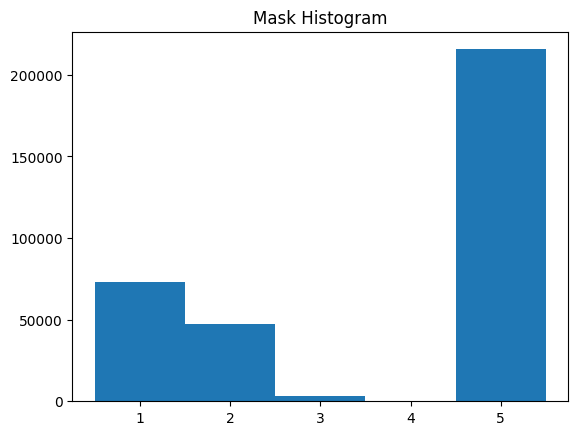

In [306]:
plt.hist(batch_masks[batch_masks > 0].flatten(), bins=5, range=(0.5, 5.5))
plt.title("Mask Histogram")
plt.show()

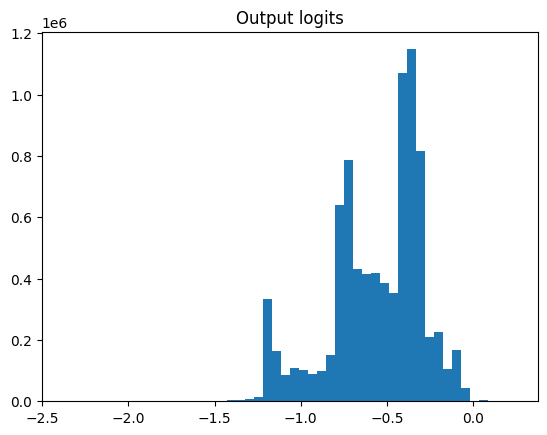

In [307]:
plt.hist(batch_outputs[:, 1:, :, :].flatten(), bins=50)
plt.title("Output logits")
plt.show()

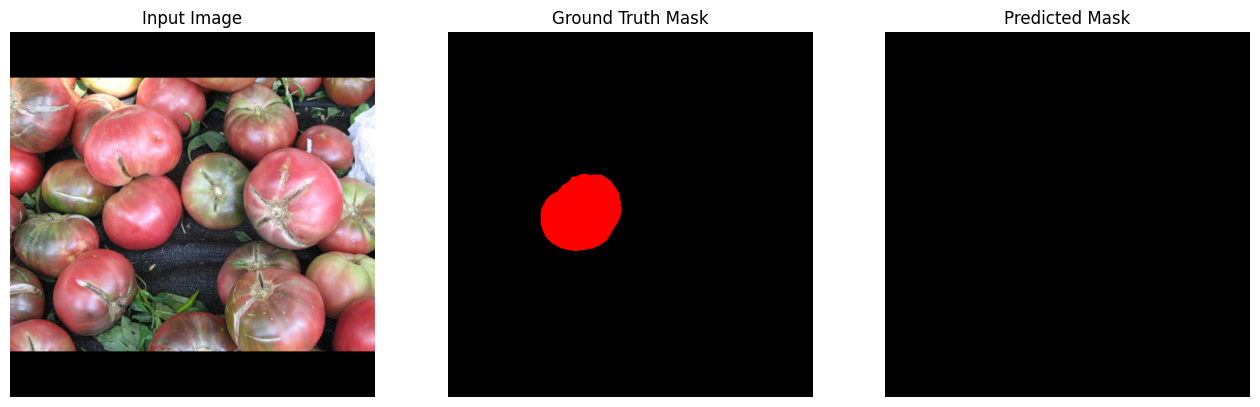

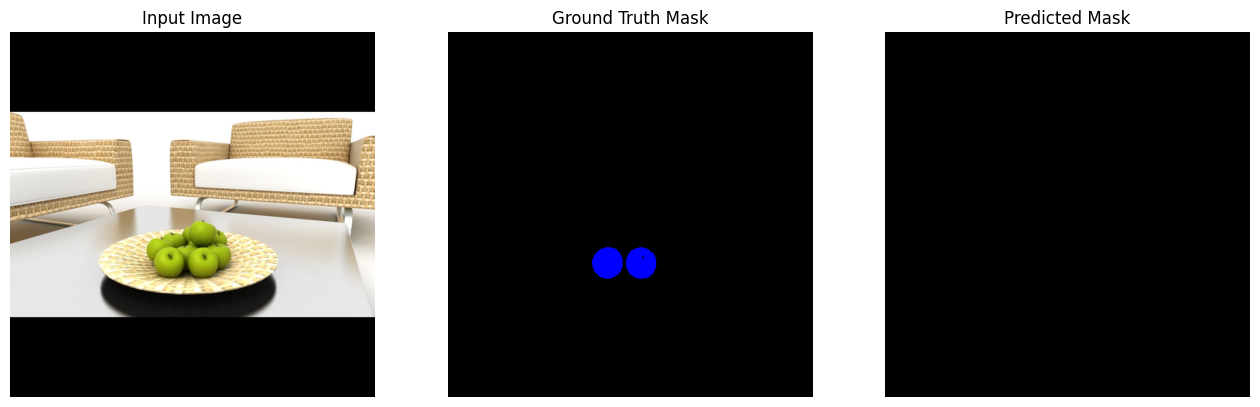

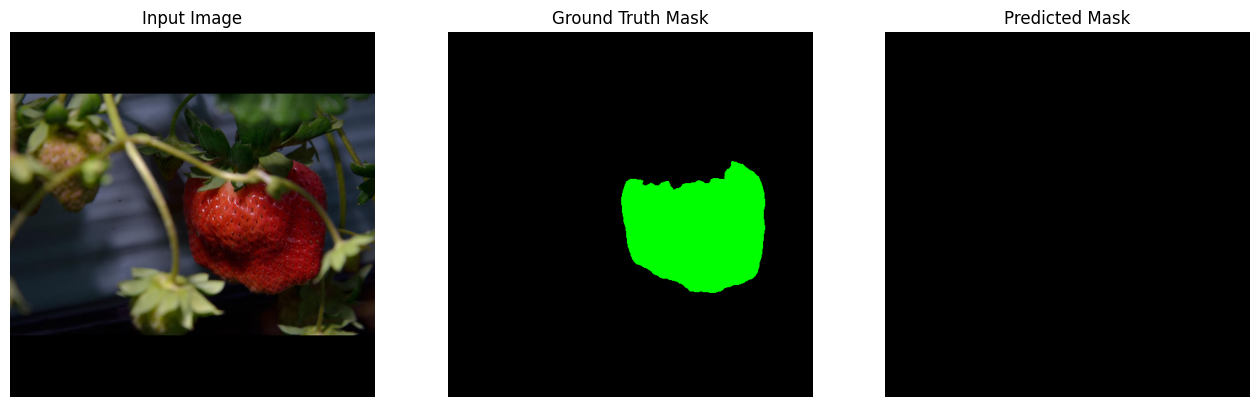

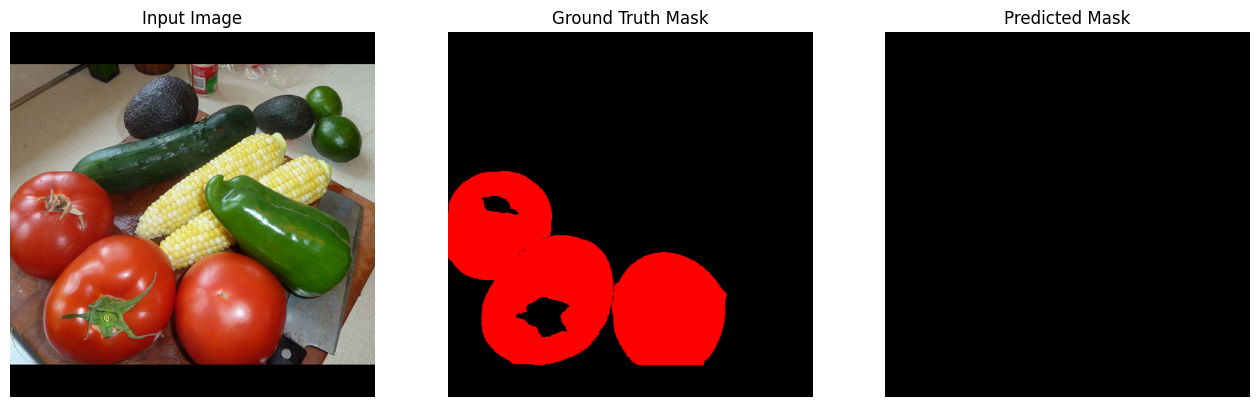

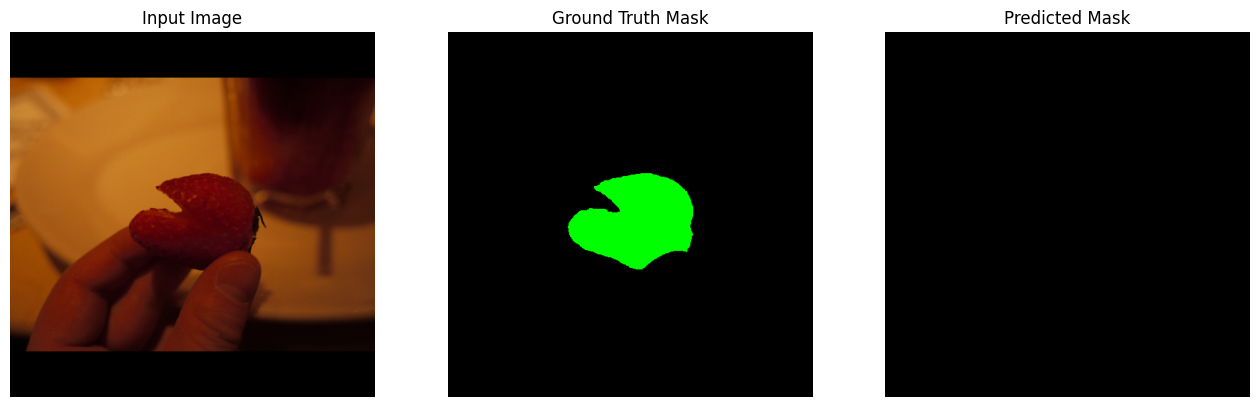

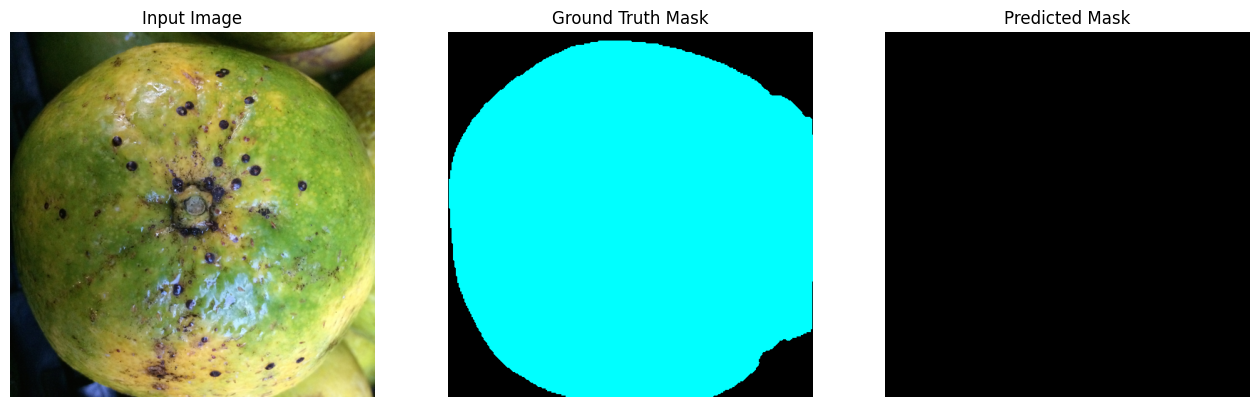

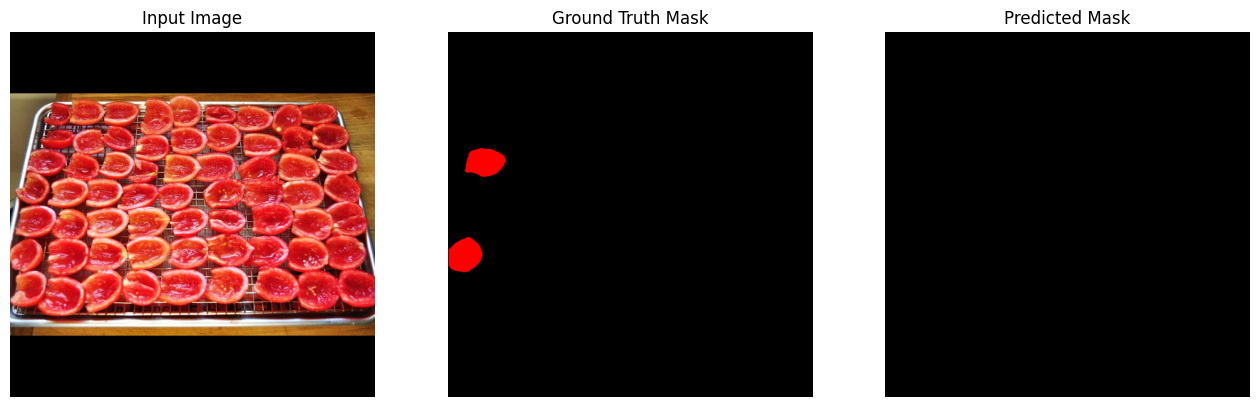

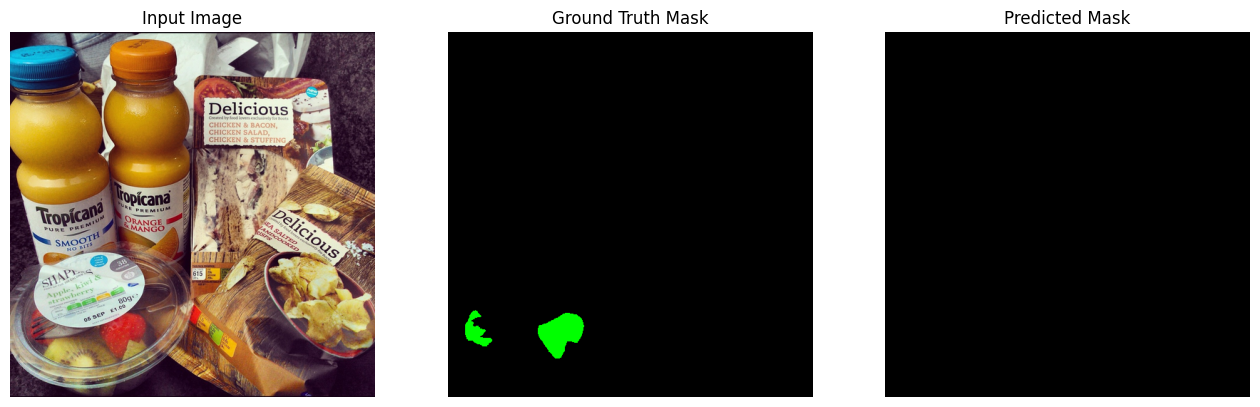

In [308]:
for idx in range(batch_size):
    this_mask = batch_masks[idx]
    this_output = batch_outputs[idx]

    plt.figure(figsize=(16, 6))
    color = {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255), 4: (255, 255, 0), 5: (0, 255, 255)}

    plt.subplot(1, 3, 1)
    plt.imshow(images[idx].cpu().detach().numpy().transpose(1, 2, 0))
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    mask_img = np.zeros((*this_mask.shape, 3), dtype=np.uint8)
    for class_idx in range(this_mask.max() + 1):
        mask_img[this_mask == class_idx] = color[class_idx]
    plt.imshow(mask_img)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    predicted_mask = np.argmax(this_output, axis=0)
    predicted_mask_img = np.zeros((*predicted_mask.shape, 3), dtype=np.uint8)
    for class_idx in range(predicted_mask.max() + 1):
        class_mask = (predicted_mask == class_idx)
        class_mask &= (this_mask[class_idx] > 0)
        predicted_mask_img[class_mask] = color[class_idx]
    plt.imshow(predicted_mask_img)
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.show()

In [250]:
# np.array(Image.open("data/images/validation/078821d86db99fc9.jpg"))

In [273]:
# plt.imshow(Image.open("/home/jupyter/dl_project1/data/masks/train/02ac8e007a385d32_m0cyhj__ad861c39.png"))